In [33]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from settings import DATA_DIR, MODEL_DIR
from src.utils import transform, wpca

import importlib
importlib.reload(wpca)

<module 'src.utils.wpca' from '/Users/lucien/Documents/projects/sst_model/src/utils/wpca.py'>

## Load data into memory

In [2]:
file = os.path.join(DATA_DIR, 'era5_west_pacific_sst.nc')
ds = xr.open_dataset(file)
arr = ds['sst'].mean(dim='expver')[:, ::2, ::2]  # Half resolution
ds.close()

# Remove seasonality and trend

In [3]:
rem_seas = transform.SeasonalityRemoverFFT(div_std=True, fft_keep_frac=0.03).fit(arr)
deseas = rem_seas.transform(arr)

rem_trend = transform.TrendRemover().fit(deseas)
detr = rem_trend.transform(deseas)

Text(0, 0.5, 'lat')

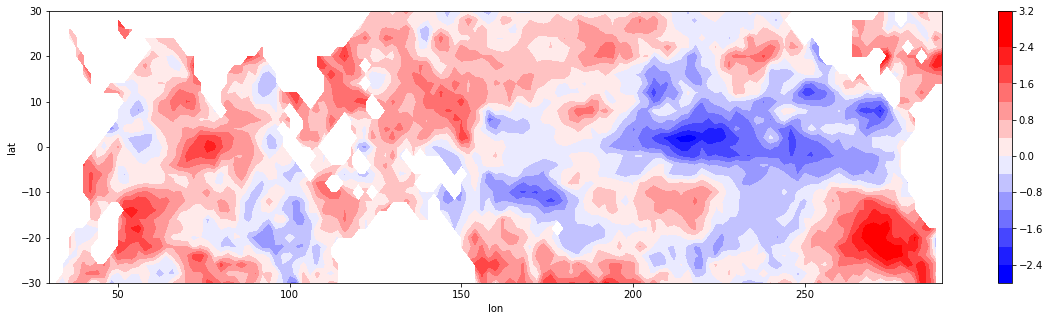

In [4]:
plt.figure(figsize=[20, 5])
c = plt.contourf(detr.coords['longitude'], detr.coords['latitude'], detr[850, :, :], cmap='bwr', vmin=-2.5, vmax=2.5, levels=15)
plt.colorbar(c)
plt.xlabel('lon')
plt.ylabel('lat')

# Perform PCA, take a look at EOFs to make sure they make sense. 

Convert to DF and perform PCA. Turn EOFs back into a DataArray so we can visualize them properly. They seem reasonable to me. 

In [5]:
da2df = transform.DataArray2DataFrame(time_dim='time').fit(detr)
df = da2df.transform(detr).dropna(how='all', axis=1)

In [6]:
n_components = 30
pca = PCA(n_components=n_components).fit(df.values)


In [7]:
eof_df = pd.DataFrame(
    index=pd.RangeIndex(0, n_components, name='eof'), 
    columns=df.columns, 
    data=pca.components_
)
eof_da = da2df.inverse_transform(eof_df)

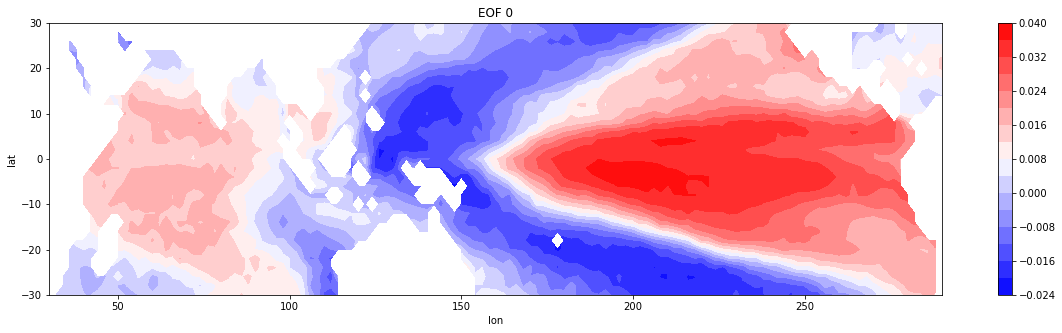

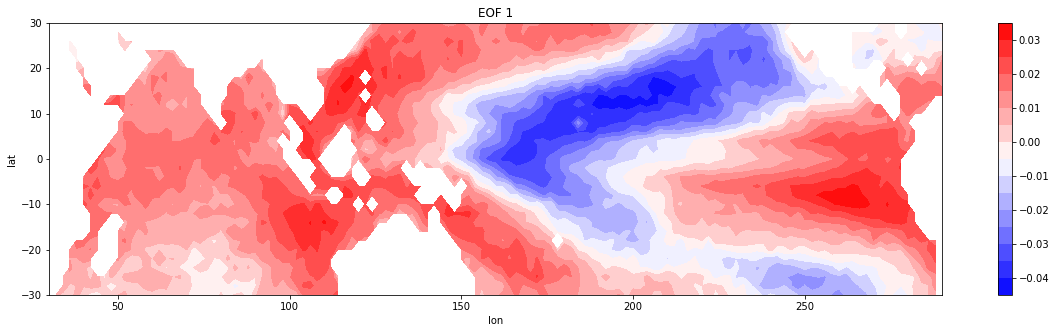

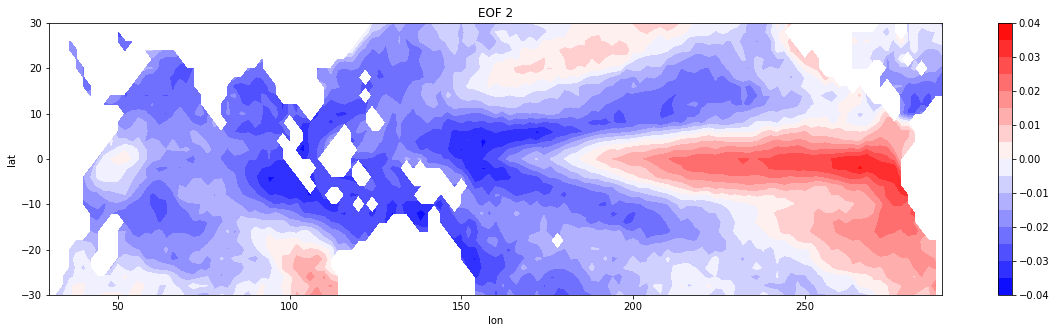

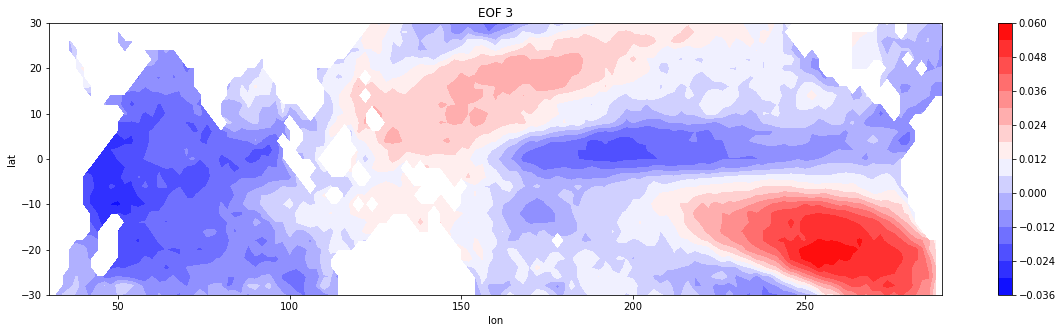

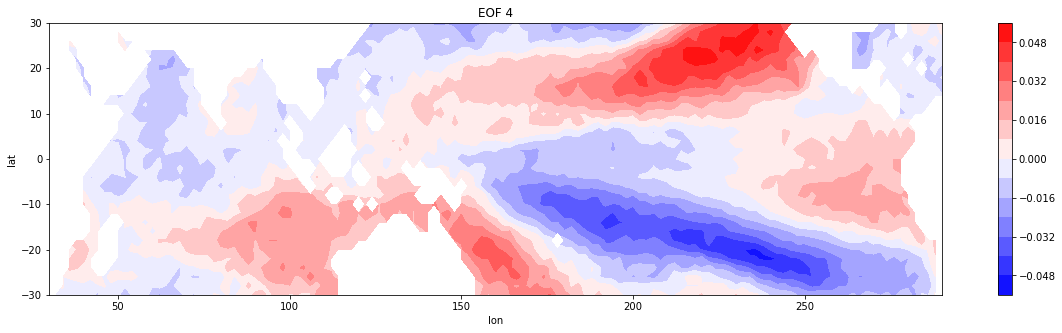

In [8]:
for n_eof in range(5): 
    plt.figure(figsize=[20, 5])
    c = plt.contourf(
        eof_da.coords['longitude'], 
        eof_da.coords['latitude'], 
        eof_da.isel(eof=n_eof), 
        cmap='bwr', levels=15
    )
    plt.colorbar(c)
    plt.xlabel('lon')
    plt.ylabel('lat')
    plt.title(f'EOF {n_eof}')
    plt.show()

# Figure out how to find EOF weightings from partial data

Create some holes in the raw data (T). 
* Find weights w that minimize error = t - E.T @ w, where t is known temperatures, E is EOFs at locations of known temperatures, and w is a vector of weights. 
* Then multiply P.T @ w, where P is matrix of EOFs at all points, to get estimated values at all points. 
* Use that to impute

In [9]:
from scipy.linalg import lstsq

test_idx = 0

# Observation vector with NaNs. 
t = df.iloc[test_idx].copy()
exclude = np.random.uniform(0, 1, size=t.shape) > 0.5
t[exclude] = np.nan
t = t.dropna()

# EOF 
E = eof_df.reindex(t.index, axis=1)
w, _, _, _ = lstsq(E.T, t)
t_hat = eof_df.T @ w


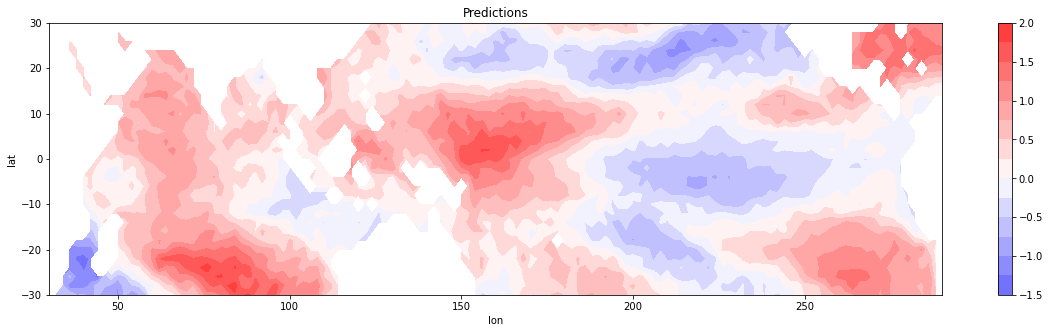

In [10]:
tmp = t_hat.to_frame().T.copy()
tmp.index.name = 'time'
preds_da = da2df.inverse_transform(tmp)

plt.figure(figsize=[20, 5])
c = plt.contourf(
    preds_da.coords['longitude'], 
    preds_da.coords['latitude'], 
    preds_da.isel(time=test_idx), 
    vmin=-2.5, vmax=2.5, 
    cmap='bwr', levels=15
)
plt.colorbar(c)
plt.xlabel('lon')
plt.ylabel('lat')
plt.title(f'Predictions')
plt.show()

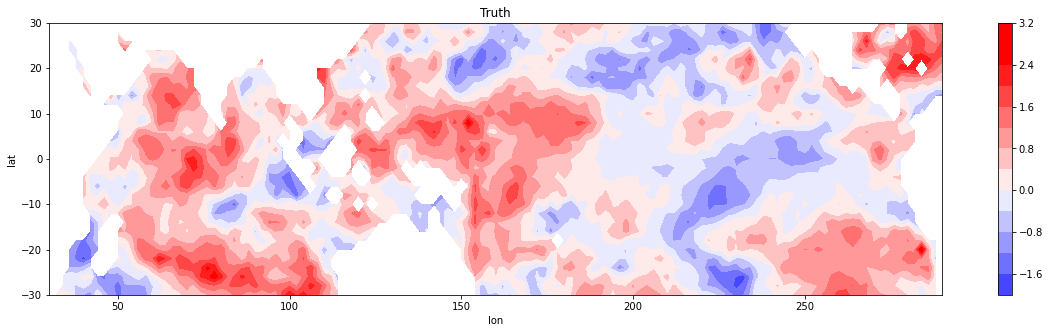

In [11]:
plt.figure(figsize=[20, 5])
c = plt.contourf(
    detr.coords['longitude'], 
    detr.coords['latitude'], 
    detr.isel(time=test_idx), 
    vmin=-2.5, vmax=2.5, 
    cmap='bwr', levels=15
)
plt.colorbar(c)
plt.xlabel('lon')
plt.ylabel('lat')
plt.title(f'Truth')
plt.show()

That looks damn good in my opinion! The predictions aren't perfect (only using 50% of points and top 30 EOFs) but the similarity is very clear! 

# Work on full process
* Start with data that has gaps. 
* Use weighted PCA to find EOFs
* Find EOF weights at each time. 
* Use EOF weights to predict SSTs at each time step. 
* Use predictions to impute values. 
* Evaluate error. 

In [37]:
# Observation vector with NaNs. 
t = df.copy()
include = np.random.uniform(0, 1, size=t.shape) > 0.5
t[~include] = np.nan
imputer = wpca.WPCAImputer(missing_values=np.nan, n_components=30, copy=True).fit(t.values)

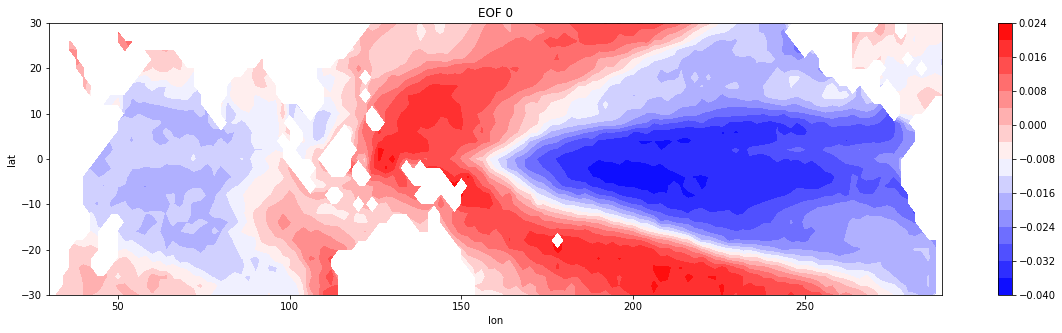

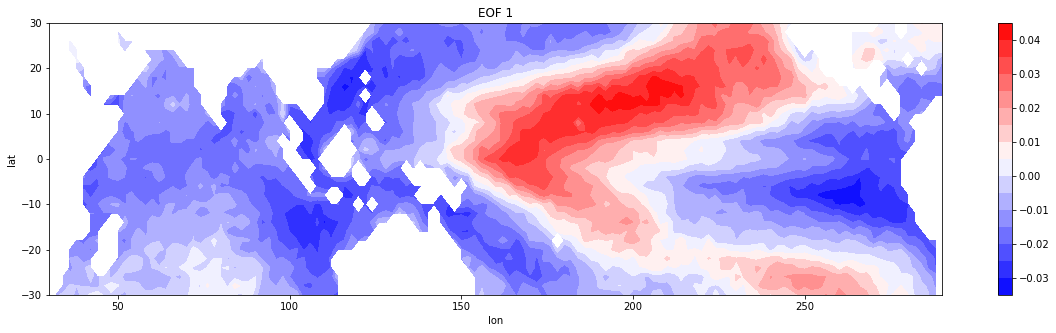

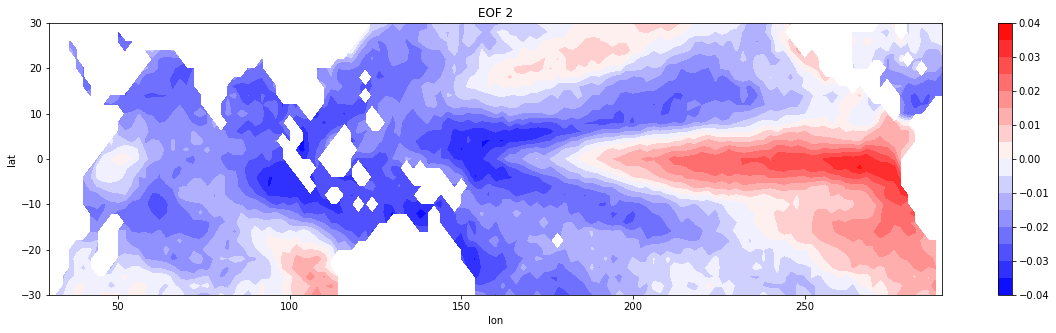

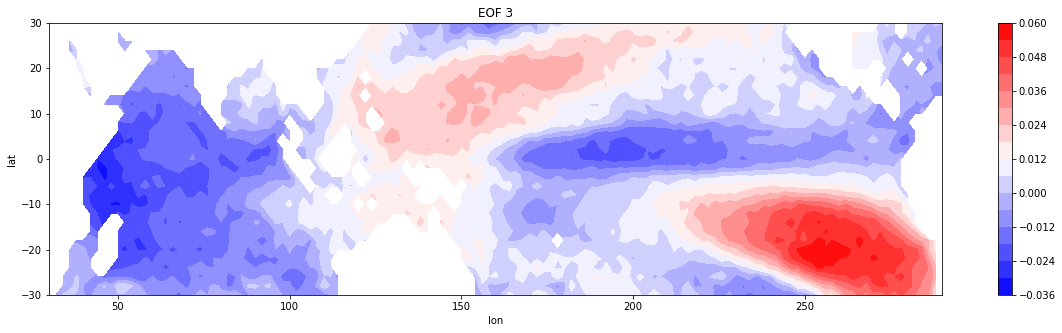

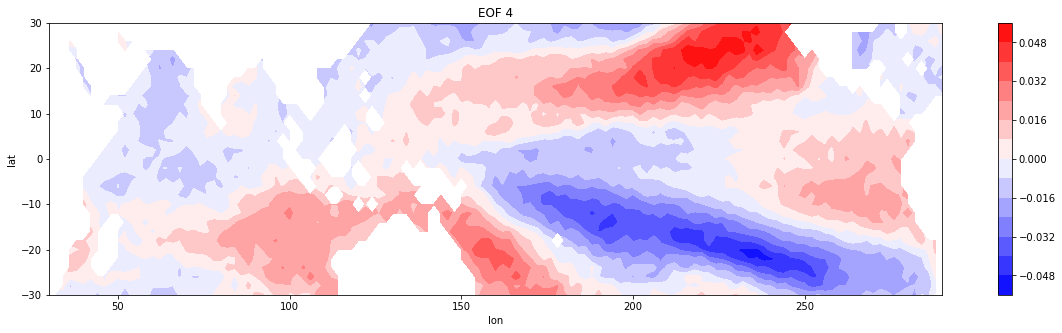

In [40]:
eof_df = pd.DataFrame(
    index=pd.RangeIndex(0, imputer.n_components, name='eof'), 
    columns=df.columns, 
    data=imputer.wpca.components_
)
eof_da = da2df.inverse_transform(eof_df)

for n_eof in range(5): 
    plt.figure(figsize=[20, 5])
    c = plt.contourf(
        eof_da.coords['longitude'], 
        eof_da.coords['latitude'], 
        eof_da.isel(eof=n_eof), 
        cmap='bwr', levels=15
    )
    plt.colorbar(c)
    plt.xlabel('lon')
    plt.ylabel('lat')
    plt.title(f'EOF {n_eof}')
    plt.show()

In [41]:
preds = pd.DataFrame(
    index=df.iloc[:1000].index, 
    columns=df.columns, 
    data=imputer.pca_predict(t.iloc[:1000].values)
)

In [42]:
preds.head()

latitude        30.0                                                    \
longitude      50.0      124.0     126.0     128.0     130.0     132.0   
time                                                                     
1979-01-01  0.323090  0.304580  0.588419  0.195445  0.367171  0.262506   
1979-01-02  0.329457  0.283292  0.611757  0.196821  0.371954  0.279701   
1979-01-03  0.374903  0.327152  0.688632  0.325527  0.431511  0.375746   
1979-01-04  0.298280  0.480389  0.821127  0.420470  0.491412  0.446623   
1979-01-05  0.206850  0.608152  0.927709  0.500638  0.536311  0.502171   

latitude                                            ...     -30.0            \
longitude      134.0     136.0     138.0     140.0  ...     270.0     272.0   
time                                                ...                       
1979-01-01 -0.040712  0.080312  0.180090  0.002729  ...  1.154714  1.148923   
1979-01-02  0.071757  0.104037  0.160093 -0.003182  ...  1.083952  1.076750   
1979-01-03  0.231555  0.189975  0.228445  0.023556  ...  1.153964  1.152185   
1979-01-04  0.318563  0.289100  0.308383  0.106678  ...  1.108140  1.112965   
1979-01-05  0.404006  0.316942  0.332345  0.092539  ...  1.231755  1.230751   

latitude                                                                \
longitude      274.0     276.0     278.0     280.0     282.0     284.0   
time                                                                     
1979-01-01  1.114387  0.938004  1.007236  0.793868  0.911802  0.665918   
1979-01-02  0.988303  0.821860  0.858208  0.660293  0.722616  0.501427   
1979-01-03  1.025050  0.878568  0.847151  0.663254  0.661303  0.499104   
1979-01-04  0.970091  0.872289  0.809833  0.633133  0.652666  0.472534   
1979-01-05  1.103545  0.994123  0.973244  0.779344  0.759934  0.588144   

latitude                        
longitude      286.0     288.0  
time                            
1979-01-01  0.698078  0.629131  
1979-01-02  0.486133  0.369719  
1979-01-03  0.442908  0.227160  
1979-01-04  0.466215  0.271444  
1979-01-05  0.572214  0.309253  

[5 rows x 3303 columns]

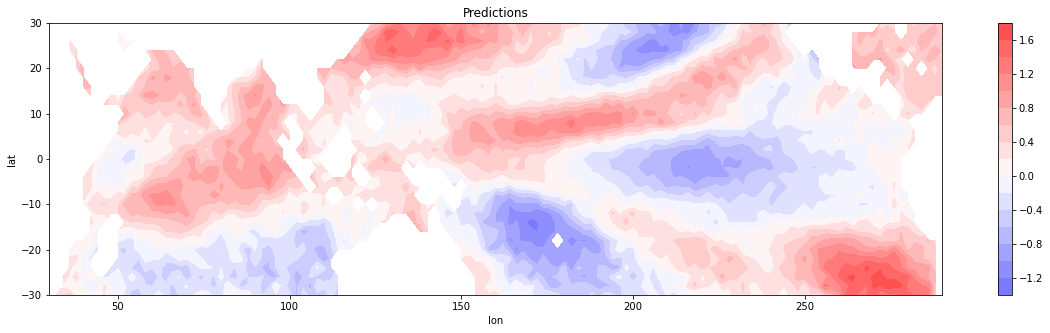

In [43]:
tmp = preds.copy()
tmp.index.name = 'time'
preds_da = da2df.inverse_transform(tmp)
test_idx = 600

plt.figure(figsize=[20, 5])
c = plt.contourf(
    preds_da.coords['longitude'], 
    preds_da.coords['latitude'], 
    preds_da.isel(time=test_idx), 
    vmin=-2.5, vmax=2.5, 
    cmap='bwr', levels=15
)
plt.colorbar(c)
plt.xlabel('lon')
plt.ylabel('lat')
plt.title(f'Predictions')
plt.show()

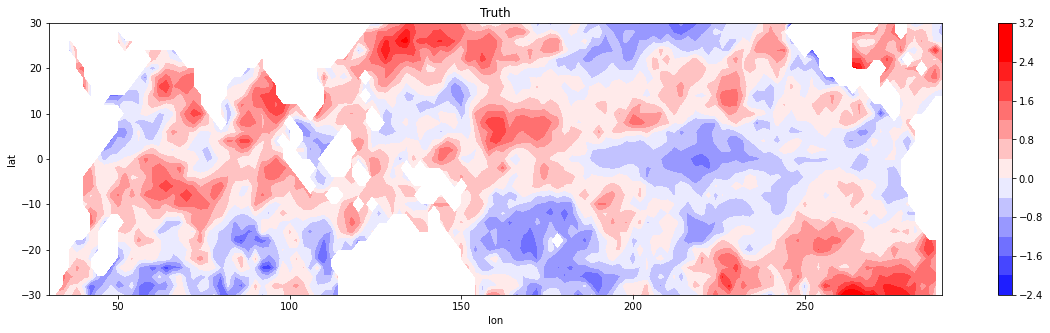

In [44]:
plt.figure(figsize=[20, 5])
c = plt.contourf(
    detr.coords['longitude'], 
    detr.coords['latitude'], 
    detr.isel(time=test_idx), 
    vmin=-2.5, vmax=2.5, 
    cmap='bwr', levels=15
)
plt.colorbar(c)
plt.xlabel('lon')
plt.ylabel('lat')
plt.title(f'Truth')
plt.show()